In [1]:
import numpy as np
import tensorflow as tf
import argparse
from shutil import copyfile
import scipy.io.wavfile as wav
import pandas as pd
import struct
import time
import os
import sys
from collections import namedtuple
sys.path.append("DeepSpeech")

try:
    import pydub
except:
    print("pydub was not loaded, MP3 compression will not work")

# Okay, so this is ugly. We don't want DeepSpeech to crash.
# So we're just going to monkeypatch TF and make some things a no-op.
# Sue me.
tf.load_op_library = lambda x: x
tmp = os.path.exists
os.path.exists = lambda x: True
class Wrapper:
    def __init__(self, d):
        self.d = d
    def __getattr__(self, x):
        return self.d[x]
class HereBeDragons:
    d = {}
    FLAGS = Wrapper(d)
    def __getattr__(self, x):
        return self.do_define
    def do_define(self, k, v, *x):
        self.d[k] = v
tf.app.flags = HereBeDragons()
import DeepSpeech
os.path.exists = tmp

# More monkey-patching, to stop the training coordinator setup
DeepSpeech.TrainingCoordinator.__init__ = lambda x: None
DeepSpeech.TrainingCoordinator.start = lambda x: None


from util.text import ctc_label_dense_to_sparse
from tf_logits import get_logits
toks = " abcdefghijklmnopqrstuvwxyz'-"

In [2]:
class Logit:
    def __init__(self, sess, max_audio_len, batch_size=1):
        
        self.sess = sess
        self.max_audio_len = max_audio_len
        
        self.original = original = tf.Variable(np.zeros((batch_size,max_audio_len), dtype=np.float32), name='qq_original')
        self.lengths = lengths = tf.Variable(np.zeros(batch_size, dtype=np.int32), name='qq_lengths') 
        pass_in = tf.clip_by_value(original, -2**15, 2**15-1)
        
        self.logits = logits = get_logits(pass_in, lengths)
        saver = tf.train.Saver([x for x in tf.global_variables() if 'qq' not in x.name])
        saver.restore(sess, "models/session_dump")
        
    def logit(self, audio, lengths):
        sess=self.sess
        sess.run(self.original.assign(np.array(audio)))
        sess.run(self.lengths.assign((np.array(lengths)-1)//320))
        
        logits = sess.run(self.logits)
        
        return logits
# the same logits framework as carlini used
# https://github.com/carlini/audio_adversarial_examples
# https://arxiv.org/abs/1801.01944

### collected logit (save npy)

In [3]:
inputs = []
for i in range(50):
     inputs.append("/ssd2/audio_adversarial_examples_dataset/final_threshold/benign_air/" + str(i) + ".wav")
with tf.Session() as sess:
    audios = []
    lengths = []
    
    for i in range(len(inputs)):
        fs, audio = wav.read(inputs[i])
        audios.append(list(audio))
        lengths.append(len(audio))
    maxlen = max(map(len,audios)) 
    audios = np.array([x+[0]*(maxlen-len(x)) for x in audios])
    
    logit = Logit(sess, maxlen, batch_size=len(audios))
    logits = logit.logit(audios,lengths)
    

INFO:tensorflow:Restoring parameters from models/session_dump


In [4]:
logits.shape

(257, 50, 29)

In [5]:
r_logits = logits

###we delete frot & back of audio because of eliminating silence part 
dummy = np.ones(shape=(50,29), dtype=float) * 1111
dummy = np.expand_dims(dummy,axis=0)
r_logits = np.concatenate((r_logits,dummy),axis=0)

In [6]:
r_logits.shape

(258, 50, 29)

In [7]:
r_logits = np.transpose(r_logits,[1,0,2])
r_logits = np.reshape(r_logits,(-1,29))
rr_logits = r_logits

In [8]:
rr_logits.shape

(12900, 29)

In [9]:
indx = []
count = 0
for i in rr_logits:
    if i[0] == 1111:
        indx.append(count)
    count += 1
### you can select the eliminating portion 
adv_indx = []
for i in indx[:-1]:
    #print(i)
    for x in range(-50,20):
        adv_indx.append(i+x)
for y in range(-50,0):
    adv_indx.append(indx[-1]+y)

In [11]:
idx = np.ones(shape=(rr_logits.shape[0]))
for k in adv_indx:
    idx[k] = 0
idx = idx == 1
rr_logits = rr_logits[idx]

In [12]:
rr_logits.shape

(9420, 29)

In [13]:
#np.save("/ssd2/attack/npy/final/p_ori.npy",rr_logits)
#save the logit as npy

In [14]:
#if dataset is cacluated, then we calculate inversion probability

In [15]:
path = "/ssd2/attack/npy/final/"
ori = np.load(path + "ori.npy")
p_ori= np.load(path + "p_ori.npy")
adv = np.load(path + "adv.npy")
p_adv = np.load(path + "p_adv.npy")

In [16]:
adv_argmax = np.argmax(adv, axis=1)
ori_argmax = np.argmax(ori, axis=1)
p_ori_argmax = np.argmax(p_ori, axis=1)
p_adv_argmax = np.argmax(p_adv, axis=1)

In [17]:
adv_sort = np.sort(adv)
ori_sort = np.sort(ori)
p_adv_sort = np.sort(p_adv)
p_ori_sort = np.sort(p_ori)


In [19]:
for i in range(2,30):
    adv_pair = adv_sort[:,[-1,-i]]
    p_adv_pair = p_adv_sort[:,[-1,-i]]
    ori_pair = ori_sort[:,[-1,-i]]
    p_ori_pair = p_ori_sort[:,[-1,-i]]
    globals()['adv_eval1{}'.format(i)] = adv_pair[:,0] - adv_pair[:,1]
    globals()['p_adv_eval1{}'.format(i)] = p_adv_pair[:,0] - p_adv_pair[:,1] 
    globals()['ori_eval1{}'.format(i)] = ori_pair[:,0] - ori_pair[:,1]
    globals()['p_ori_eval1{}'.format(i)] = p_ori_pair[:,0] - p_ori_pair[:,1]

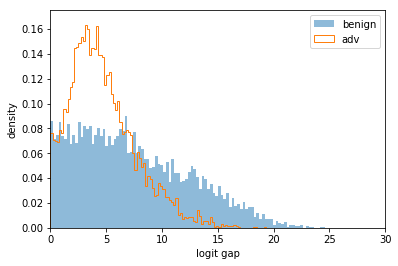

In [21]:
import matplotlib.pyplot as plt


#plt.hist(p_adv_eval13, bins=100, density=True, alpha=0.6, histtype="step")
plt.hist(ori_eval12, bins=100, density=True, alpha=0.5, histtype='stepfilled')
plt.hist(adv_eval12, bins=100, density=True, alpha=1, histtype="step")
plt.axis([0,30,0,0.175])
#plt.hist(p_ori_eval12, bins=100, density=True, alpha=0.7, histtype="stepfilled")
plt.xlabel('logit gap')
plt.ylabel('density')
plt.legend(['benign','adv'])
#plt.legend(['p_adv','ori','adv','p_ori'])
plt.show()

### 1-k inversion probaiblity

In [ ]:

# import numpy as np
# from scipy.stats import norm
# def noise_effect(difference= 3, noise=3, sampling=26):
#     total = 0
#     s = np.random.normal(0,noise,sampling)
#     for i in s:
#         total += norm.cdf(i+difference,0,noise)
#     return (1- total/sampling)

# std_list = [0.1,0.5,1,1.5,2,2.5,3,3.2,3.5,4,4.5,5,5.5,6]    
# for xx in range(2,30):
#     globals()['adv_list{}'.format(xx)] = []
#     globals()['p_adv_list{}'.format(xx)] = []
#     globals()['ori_list{}'.format(xx)] = []
#     globals()['p_ori_list{}'.format(xx)] = []
    
#     print(xx)
#     for std in std_list:
#         print("std:",std)
#         adv_sums = 0
#         p_adv_sums = 0
#         ori_sums = 0
#         p_ori_sums = 0
#         for x in globals()['adv_eval1{}'.format(xx)]:
#             adv_sums += (1/len(globals()['adv_eval1{}'.format(xx)]))*noise_effect(x,std,29)
#         print(adv_sums)
#         for x in globals()['p_adv_eval1{}'.format(xx)]:
#             p_adv_sums += (1/len(globals()['p_adv_eval1{}'.format(xx)]))*noise_effect(x,std,29)
#         print(p_adv_sums)
#         for x in globals()['ori_eval1{}'.format(xx)]:
#             ori_sums += (1/len(globals()['ori_eval1{}'.format(xx)]))*noise_effect(x,std,29)
#         print(ori_sums)
#         for x in globals()['p_ori_eval1{}'.format(xx)]:
#             p_ori_sums += (1/len(globals()['p_ori_eval1{}'.format(xx)]))*noise_effect(x,std,29)
#         print(p_ori_sums)
        
#         globals()['adv_list{}'.format(xx)].append(adv_sums)
#         globals()['p_adv_list{}'.format(xx)].append(p_adv_sums)
#         globals()['ori_list{}'.format(xx)].append(ori_sums)
#         globals()['p_ori_list{}'.format(xx)].append(p_ori_sums)